### Importando as bibliotecas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

### Explorando os dados

In [2]:
# Carregando os dados
dados = pd.read_csv('Dados\\flights.csv')
dados.head()

,flight_id,airline,aircraft_type,schengen,origin,arrival_time,departure_time,day,year,is_holiday,delay
0,26,MM,Airbus A320,non-schengen,TCY,8.885071,10.885071,0,2010,False,70.205981
1,10,YE,Airbus A320,non-schengen,TCY,8.939996,11.939996,0,2010,False,38.484609
2,3,BZ,Embraer E175,schengen,TZF,18.635384,22.635384,0,2010,False,2.388305
3,28,BZ,Airbus A330,non-schengen,EMM,15.967963,17.967963,0,2010,False,19.138491
4,15,BZ,Airbus A330,non-schengen,FJB,16.571894,19.571894,0,2010,False,15.016271


In [3]:
# Verificando o tamanho do dataset
dados.shape

(71175, 11)

In [4]:
# Verificando os tipos de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71175 entries, 0 to 71174
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       71175 non-null  int64  
 1   airline         71175 non-null  object 
 2   aircraft_type   71175 non-null  object 
 3   schengen        71175 non-null  object 
 4   origin          71175 non-null  object 
 5   arrival_time    71175 non-null  float64
 6   departure_time  71175 non-null  float64
 7   day             71175 non-null  int64  
 8   year            71175 non-null  int64  
 9   is_holiday      71175 non-null  bool   
 10  delay           71175 non-null  float64
dtypes: bool(1), float64(3), int64(3), object(4)
memory usage: 5.5+ MB


In [5]:
# Verificando as informações estatísticas das colunas numéricas.
dados.describe()

,flight_id,arrival_time,departure_time,day,year,delay
count,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000,71175.000000
mean,15.465135,13.283159,16.480222,182.000000,2016.000000,12.548378
std,8.649646,4.023380,4.143705,105.366769,3.741684,23.125349
min,1.000000,7.065594,10.065594,0.000000,2010.000000,-41.028033
25%,8.000000,8.939996,12.668655,91.000000,2013.000000,-4.412876
50%,15.000000,14.258911,16.376052,182.000000,2016.000000,9.740454
75%,23.000000,16.909690,20.041281,273.000000,2019.000000,27.650853
max,30.000000,19.341235,23.341235,364.000000,2022.000000,125.632352


In [6]:
# Verificando as informações das colunas categóricas.
dados.describe(include=['O'])

,airline,aircraft_type,schengen,origin
count,71175,71175,71175,71175
unique,3,6,2,10
top,BZ,Airbus A320,schengen,TZF
freq,47598,30778,42569,14162


### Análises Gráficas dos dados

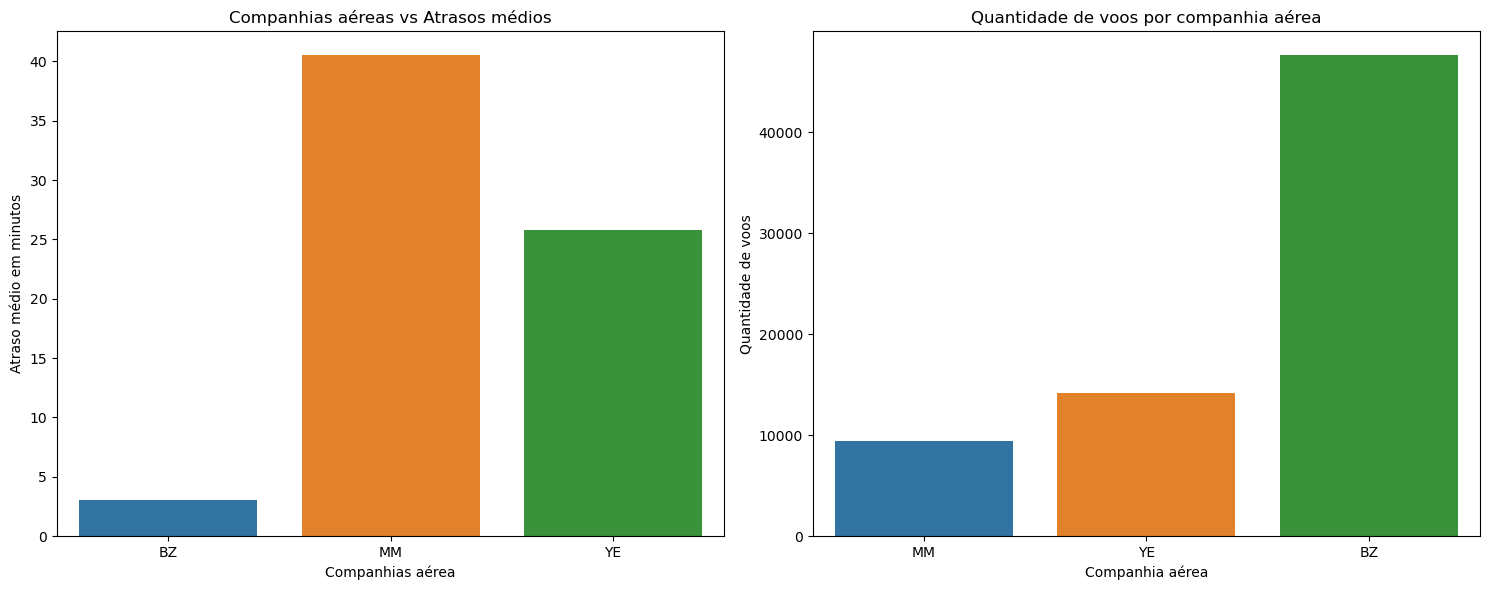

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['airline'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='airline', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Companhias aéreas vs Atrasos médios', xlabel='Companhias aérea', ylabel='Atraso médio em minutos')

ax2 = sns.countplot(x='airline', data=dados, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Companhia aérea', ylabel='Quantidade de voos')

plt.tight_layout()
plt.show()

Nos gráficos apresentados, um interessante padrão se revela: a Companhia MM, apesar de operar menos voos, destaca-se pelo tempo médio de atraso mais longo entre todas as companhias. Enquanto isso, a Companhia BZ lidera em número de voos, porém surpreende com um tempo médio de atraso incrivelmente curto. Já a Companhia YE se posiciona em um ponto intermediário, sem alcançar os extremos das outras duas companhias, tanto em quantidade de voos quanto no tempo médio de atraso.

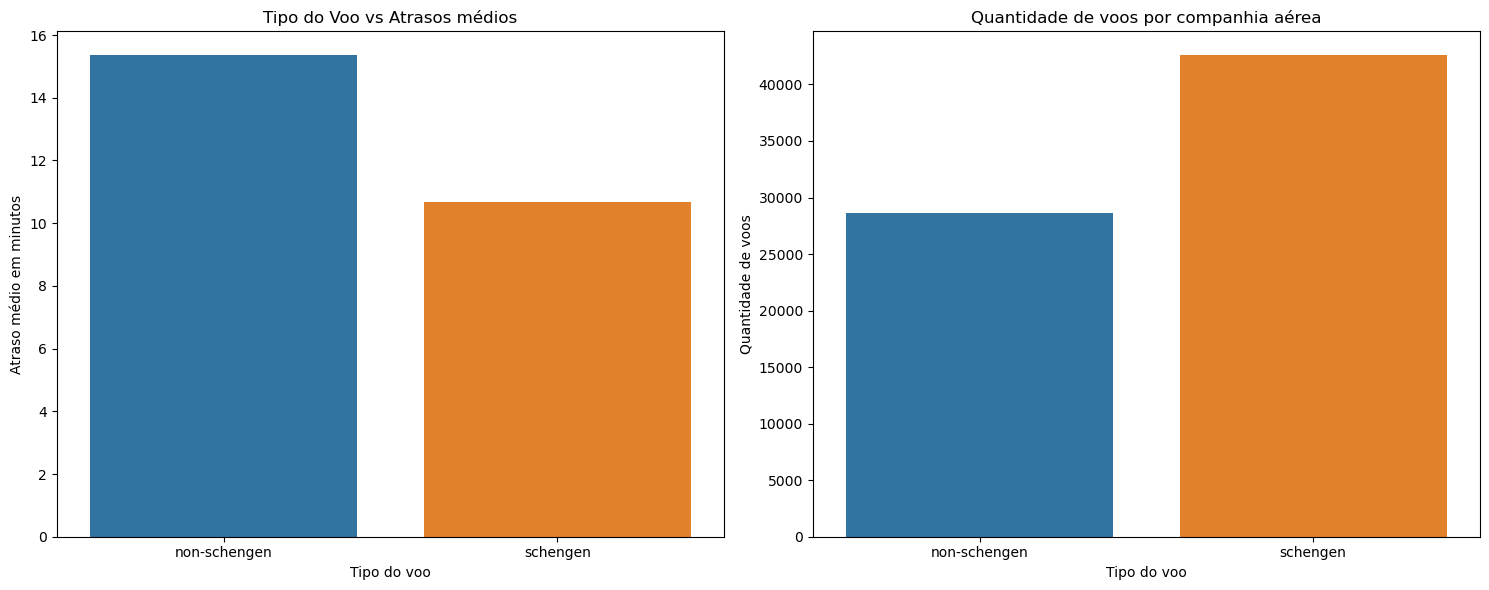

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['schengen'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='schengen', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Tipo do Voo vs Atrasos médios', xlabel='Tipo do voo', ylabel='Atraso médio em minutos')

ax2 = sns.countplot(x='schengen', data=dados, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Tipo do voo', ylabel='Quantidade de voos')

plt.tight_layout()
plt.show()

Observando os gráficos acima, notamos que os voos com destino ao Espaço Schengen predominam, apresentando um tempo médio de atraso em torno de 10 minutos. Por outro lado, os voos para países fora desse acordo têm um tempo médio de atraso superior ao primeiro grupo mencionado, variando em torno de 5 minutos a mais.

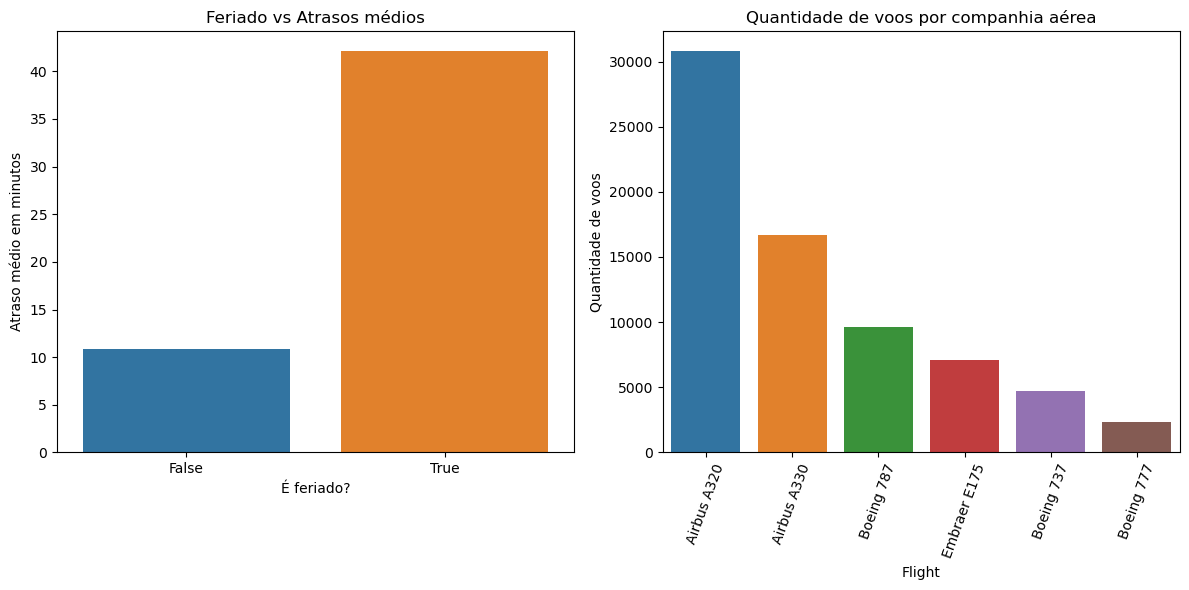

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

average_delay = dados.groupby(['is_holiday'])['delay'].mean().reset_index()
ax1 = sns.barplot(x='is_holiday', y='delay', data=average_delay, ax=axes[0])
ax1.set(title='Feriado vs Atrasos médios', xlabel='É feriado?', ylabel='Atraso médio em minutos')

order = dados['aircraft_type'].value_counts().index
ax2 = sns.countplot(x='aircraft_type', data=dados, order=order, ax=axes[1])
ax2.set(title='Quantidade de voos por companhia aérea', xlabel='Flight', ylabel='Quantidade de voos')
plt.xticks(rotation=70)

plt.tight_layout()
plt.show()

Podemos observar que nos feriados, pelo gráfico à esquerda, há uma incidência maior de atrasos em comparação aos dias úteis. Já no gráfico à direita, chama a atenção que os voos da Airbus estão mais propensos a atrasos quando comparados com outros tipos de voos.

### Análise da distribuição dos dados

In [10]:
def calcular_largura_bin(df, coluna):
    Q75, Q25 = np.percentile(df[coluna],[75,25])
    IQR = Q75 - Q25
    largura_bin = 2 * IQR * np.power(len(df[coluna]), -1/3)
    return largura_bin

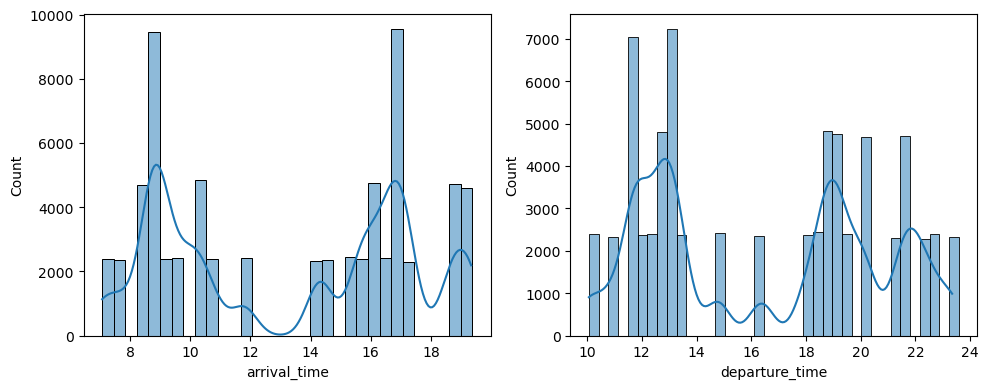

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

largura_bin_at = calcular_largura_bin(dados, 'arrival_time')
ax1 = sns.histplot(data=dados, x='arrival_time', bins=10, kde=True, binwidth=largura_bin_at, ax=axes[0])

largura_bin_dt = calcular_largura_bin(dados, 'departure_time')
ax2 = sns.histplot(data=dados, x='departure_time', bins=10, kde=True, binwidth=largura_bin_dt, ax=axes[1])

plt.tight_layout()
plt.show()

No primeiro histograma a esquerda, podemos observar que são esses os horários em que há mais voos chegando no aeroporto: por volta das 9h e por volta das 17h, com o pico subindo e descendo.

Ao observar o segundo histograma, parece haver um padrão interessante ao redor do meio-dia, onde há um aumento significativo no número de voos, seguido por uma diminuição e, logo após, outro pico. É possível que esses voos do meio-dia estejam conectados aos que chegam por volta das 9 horas, como analisamos anteriormente. Essa relação parece se repetir por volta das 18 e 19 horas. Por exemplo, próximos às 19 horas, é esperado que os voos que chegaram por volta das 17 horas partam nesse horário.

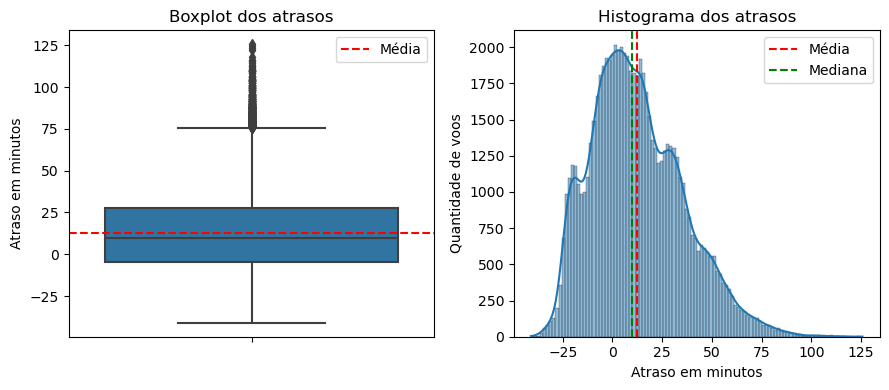

In [12]:
mean_delay = dados['delay'].mean()
median_delay = dados['delay'].median()

fig, axes = plt.subplots(1, 2, figsize=(9, 4))

sns.boxplot(data=dados, y='delay', ax=axes[0])
axes[0].set(title='Boxplot dos atrasos', ylabel='Atraso em minutos')
axes[0].axhline(y=mean_delay, ls='--', color='red', label='Média')
axes[0].legend()

largura_bin_delay = calcular_largura_bin(dados, 'delay')
sns.histplot(data=dados, x='delay', kde=True, ax=axes[1], binwidth=largura_bin_delay)
plt.ylabel('Quantidade de voos')
plt.grid(False)
axes[1].set(title='Histograma dos atrasos', xlabel='Atraso em minutos')
axes[1].axvline(x=mean_delay, ls='--', color='red', label='Média')
axes[1].axvline(x=median_delay, ls='--', color='green', label='Mediana')
axes[1].legend()

plt.tight_layout()
plt.show()

No boxplot gerado, podemos notar que mesmo com outliers, eles não afetam drasticamente a forma do gráfico. Parecem ser possíveis valores atípicos, mas provavelmente representam casos isolados dentro do nosso conjunto de dados, que mantém a média em torno de 15, mais ou menos.

Ao analisar a distribuição da variável alvo, imprimimos a média e a mediana, notando uma leve assimetria à direita. No entanto, essa assimetria não parece comprometer a qualidade dos dados. Era esperado que a distribuição apresentasse essa inclinação, mas surpreendentemente, ela está relativamente próxima da normalidade, sem uma assimetria tão pronunciada para o lado direito.